In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Mount Google Drive (if dataset is stored there)
from google.colab import drive
drive.mount('/content/drive')

# Load dataset - replace with your path or use Colab's file upload
# For Colab, you can upload the file directly or use:
# from keras.datasets import imdb
# (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

# For CSV file (assuming you've uploaded IMDB_Dataset.csv)
df = pd.read_csv('IMDB Dataset.csv')  # Update path as needed
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [5]:
def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    """Clean and preprocess text data"""
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z]", " ", text)

    # Convert to lowercase and split into words
    words = text.lower().split()

    # Optionally remove stopwords
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if w not in stops]

    # Optionally lemmatize words
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(w) for w in words]

    return " ".join(words)

# Balance classes if needed
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Preprocess reviews
df['clean_review'] = df['review'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'], df['sentiment'], test_size=0.2, random_state=42
)

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 200
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Hyperparameters
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.3
learning_rate = 0.001

# Build model
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(32)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()],
    run_eagerly=False
)

# Callbacks
callbacks = [
    EarlyStopping(patience=3, monitor='val_auc', mode='max', verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_auc', save_best_only=True, mode='max')
]

# Train model
history = model.fit(
    train_padded, y_train,
    validation_data=(test_padded, y_test),
    epochs=15,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7684 - auc: 0.8469 - loss: 0.4588

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.7686 - auc: 0.8471 - loss: 0.4586 - val_accuracy: 0.8795 - val_auc: 0.9471 - val_loss: 0.3085
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - accuracy: 0.9092 - auc: 0.9628 - loss: 0.2422 - val_accuracy: 0.8795 - val_auc: 0.9443 - val_loss: 0.3282
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9297 - auc: 0.9768 - loss: 0.1896 - val_accuracy: 0.8758 - val_auc: 0.9435 - val_loss: 0.3448
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.9447 - auc: 0.9856 - loss: 0.1492 - val_accuracy: 0.8738 - val_auc: 0.9414 - val_loss: 0.3231
Epoch 4: early stopping


Model Evaluation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4961
           1       0.87      0.87      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

ROC AUC Score: 0.9416


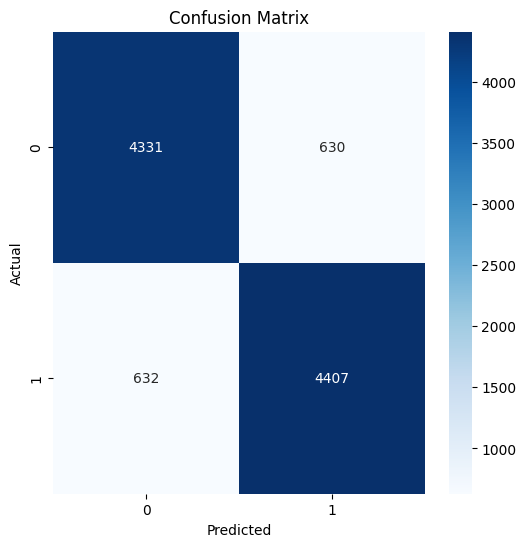

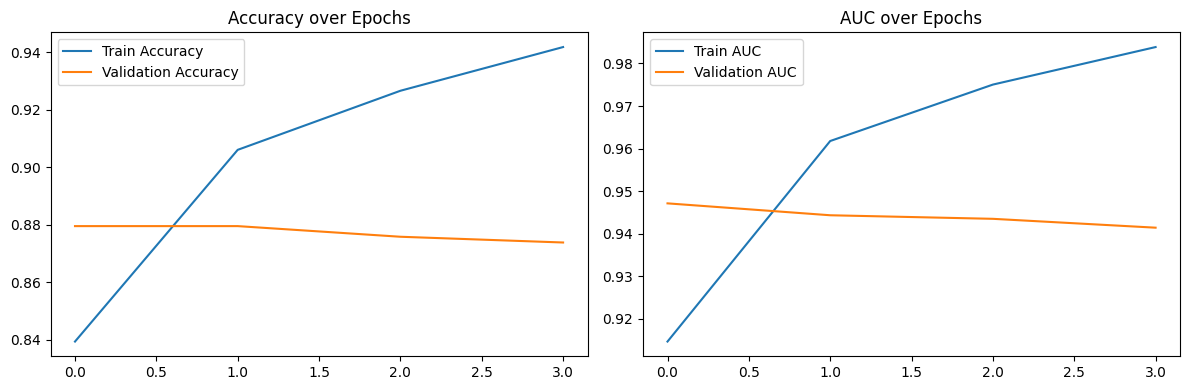

In [8]:
def evaluate_model(model, X_test, y_test):
    # Predict probabilities and classes
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Classification report
    print(classification_report(y_test, y_pred))

    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('AUC over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return roc_auc

# Evaluate model
print("Model Evaluation:")
lstm_roc = evaluate_model(model, test_padded, y_test)

In [9]:
# Interactive prediction function
def predict_sentiment(text):
    # Preprocess
    clean_text = preprocess_text(text)

    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Predict
    prediction = model.predict(padded)[0][0]
    sentiment = 'positive' if prediction > 0.5 else 'negative'
    confidence = prediction if sentiment == 'positive' else 1 - prediction

    print(f"Review: {text}")
    print(f"Sentiment: {sentiment.upper()} (confidence: {confidence*100:.2f}%)")
    return sentiment, confidence

# Test with sample reviews
sample_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot was engaging.",
    "I hated this film. It was boring and the characters were poorly developed.",
    "The cinematography was beautiful but the story made no sense.",
    "Not bad, but I've seen better movies in this genre.",
    "This was the worst movie I've ever seen in my entire life."
]

for review in sample_reviews:
    predict_sentiment(review)
    print("-" * 80)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Review: This movie was absolutely fantastic! The acting was superb and the plot was engaging.
Sentiment: POSITIVE (confidence: 92.15%)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Review: I hated this film. It was boring and the characters were poorly developed.
Sentiment: NEGATIVE (confidence: 99.87%)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Review: The cinematography was beautiful but the story made no sense.
Sentiment: POSITIVE (confidence: 57.19%)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Review: Not bad, but I've seen better movies in this genre.
Sentiment: NEGATIVE (confidence: 70.53%)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Review: This wa

In [10]:
# Save model and tokenizer
model.save('imdb_sentiment_model.h5')

import pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# To load later:
# from tensorflow.keras.models import load_model
# model = load_model('imdb_sentiment_model.h5')
# with open('tokenizer.pkl', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [12]:
# Define test reviews (you can modify these)
sample_test_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot was engaging.",
    "I hated this film. It was boring and the characters were poorly developed.",
    "The cinematography was beautiful but the story made no sense.",
    "Not bad, but I've seen better movies in this genre.",
    "This was the worst movie I've ever seen in my entire life.",
    "The director did a great job, though some scenes felt unnecessary.",
    "I fell asleep halfway through the movie - completely disappointing.",
    "An instant classic that will be remembered for years to come!"
]

# Function to predict and display results
def test_reviews(reviews, model, tokenizer, max_length=200):
    for i, review in enumerate(reviews, 1):
        # Preprocess
        clean_text = preprocess_text(review)

        # Tokenize and pad
        sequence = tokenizer.texts_to_sequences([clean_text])
        padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

        # Predict
        prediction = model.predict(padded, verbose=0)[0][0]
        sentiment = 'POSITIVE' if prediction > 0.5 else 'NEGATIVE'
        confidence = prediction if sentiment == 'POSITIVE' else 1 - prediction

        # Display results
        print(f"\nReview {i}:")
        print("-" * 50)
        print(f"TEXT: {review}")
        print(f"\nPREDICTION: {sentiment} (confidence: {confidence*100:.2f}%)")
        print(f"RAW SCORE: {prediction:.4f}")

# Run the test
print("Testing Model with Sample Reviews:")
test_reviews(sample_test_reviews, model, tokenizer) # Use the renamed list here

Testing Model with Sample Reviews:

Review 1:
--------------------------------------------------
TEXT: This movie was absolutely fantastic! The acting was superb and the plot was engaging.

PREDICTION: POSITIVE (confidence: 92.15%)
RAW SCORE: 0.9215

Review 2:
--------------------------------------------------
TEXT: I hated this film. It was boring and the characters were poorly developed.

PREDICTION: NEGATIVE (confidence: 99.87%)
RAW SCORE: 0.0013

Review 3:
--------------------------------------------------
TEXT: The cinematography was beautiful but the story made no sense.

PREDICTION: POSITIVE (confidence: 57.19%)
RAW SCORE: 0.5719

Review 4:
--------------------------------------------------
TEXT: Not bad, but I've seen better movies in this genre.

PREDICTION: NEGATIVE (confidence: 70.53%)
RAW SCORE: 0.2947

Review 5:
--------------------------------------------------
TEXT: This was the worst movie I've ever seen in my entire life.

PREDICTION: NEGATIVE (confidence: 98.22%)
RAW 

In [13]:
# Interactive testing cell
while True:
    print("\n" + "="*50)
    print("Enter a movie review to analyze (or type 'quit' to exit):")
    user_input = input()

    if user_input.lower() in ['quit', 'exit', 'q']:
        break

    # Preprocess
    clean_text = preprocess_text(user_input)

    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Predict
    prediction = model.predict(padded, verbose=0)[0][0]
    sentiment = 'POSITIVE' if prediction > 0.5 else 'NEGATIVE'
    confidence = prediction if sentiment == 'POSITIVE' else 1 - prediction

    # Display results
    print("\nRESULTS:")
    print("-" * 30)
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {confidence*100:.2f}%")
    print(f"Raw Score: {prediction:.4f}")

    # Show attention (if using attention layers)
    if hasattr(model.layers[1], 'attention'):
        attention_model = tf.keras.models.Model(
            inputs=model.inputs,
            outputs=[model.outputs, model.layers[1].output]
        )
        _, attention_weights = attention_model.predict(padded)

        # Get important words
        tokens = tokenizer.sequences_to_texts(sequence)[0].split()
        attention_weights = attention_weights[0][:len(tokens)]

        print("\nKey Words:")
        for word, weight in zip(tokens, attention_weights):
            if weight > 0.1:  # Threshold for important words
                print(f"{word} ({weight:.2f})", end=" | ")


Enter a movie review to analyze (or type 'quit' to exit):
movie is not that good

RESULTS:
------------------------------
Sentiment: POSITIVE
Confidence: 59.43%
Raw Score: 0.5943

Enter a movie review to analyze (or type 'quit' to exit):


KeyboardInterrupt: Interrupted by user

In [15]:
# In your Colab notebook, add this cell first to ensure GitHub rendering
!jupyter nbconvert --to markdown IMDB_Sentiment_Analysis.ipynb


[NbConvertApp] WARNING | pattern 'IMDB_Sentiment_Analysis.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
-